In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import shap

In [2]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 'income']

data = pd.read_csv(url, names=columns, na_values=" ?", sep=',\s', engine='python')


In [3]:
# Data preprocessing
data.dropna(inplace=True)
label_encoder = LabelEncoder()

# Encoding categorical variables
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 
                    'relationship', 'race', 'sex', 'native-country', 'income']
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Feature and target split
X = data.drop('income', axis=1)
y = data['income']

In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [5]:
# Predictions and accuracy
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8259

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89      7455
           1       0.71      0.45      0.55      2314

    accuracy                           0.83      9769
   macro avg       0.78      0.70      0.72      9769
weighted avg       0.81      0.83      0.81      9769



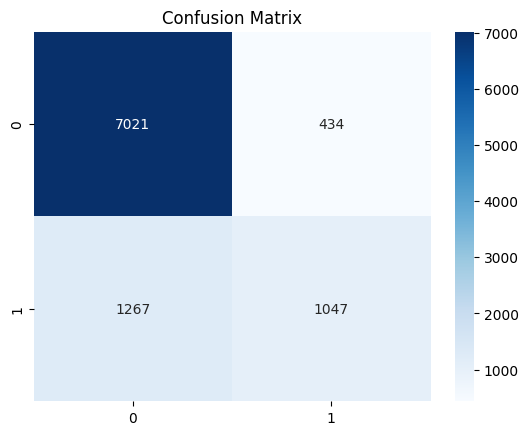

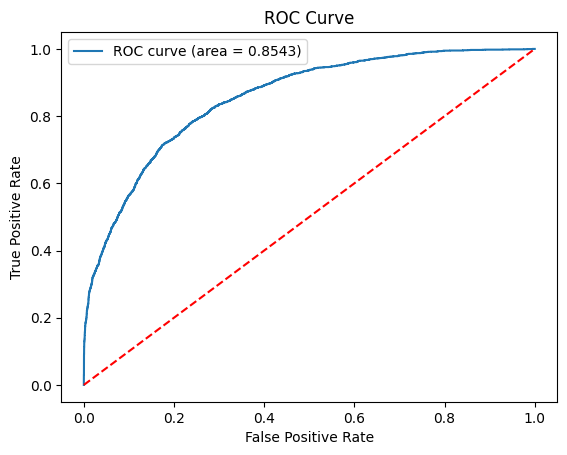

In [7]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve and AUC
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

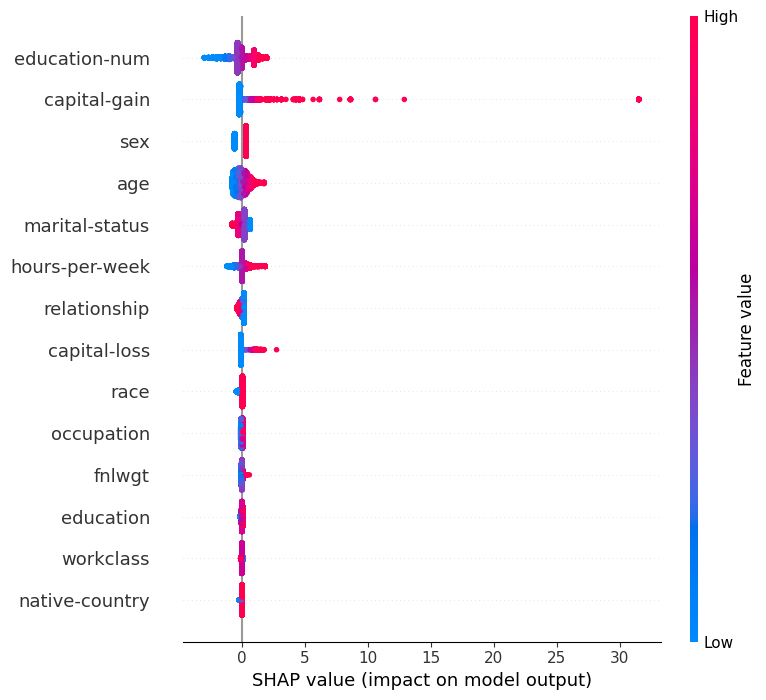

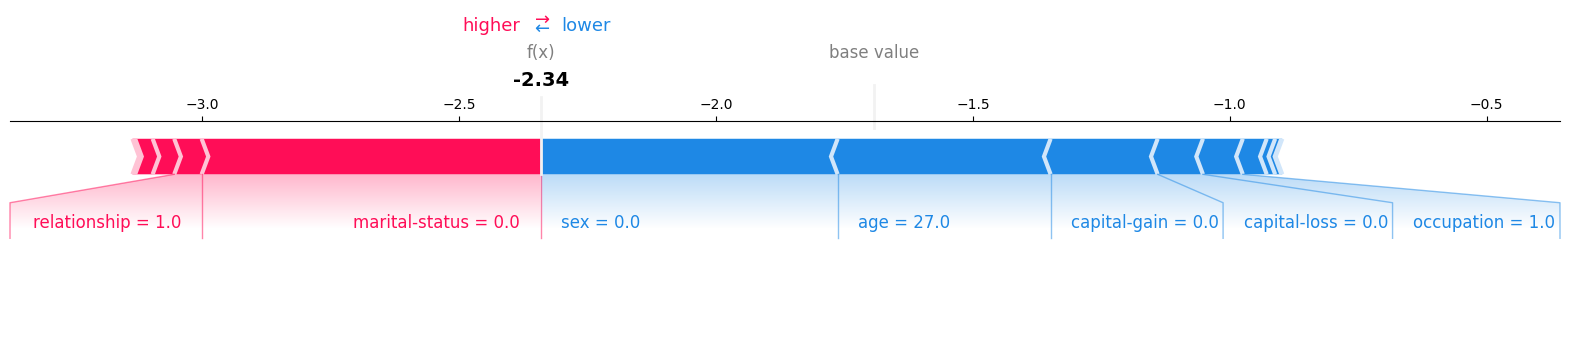

In [8]:
# SHAP Analysis
explainer = shap.LinearExplainer(model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

# SHAP Force Plot
# To display the force plot for a single prediction (e.g., the first test instance):
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)

## Force Plot Interpretation:

- The SHAP force plot shows the contribution of each feature towards decreasing or increasing the model’s prediction (log-odds in this case).
- Features pushing the prediction higher (towards positive prediction) are shown in red.
- Features pushing the prediction lower (towards negative prediction) are shown in blue.
- The base value is the expected model output (in log-odds), and the final prediction (f(x) = -2.34) represents the combined impact of all the features.

## Key Feature Contributions:

- Relationship (1.0) and Marital-status (0.0) are the strongest contributors towards pushing the model prediction higher (towards a higher class or income bracket), shown in red.
- Age (27.0), Capital-gain (0.0), and Capital-loss (0.0), along with Occupation (1.0), are contributing to pushing the prediction lower, shown in blue.

## Potential Bias in Features:

- Relationship: This feature is contributing significantly to the prediction, indicating a potential bias towards certain relationship statuses in determining income. This could imply that the model is making assumptions about individuals in certain relationship statuses (e.g., single, married) that may not be entirely justifiable.
- Marital Status: Like the relationship feature, marital status is playing a strong role in pushing predictions towards a specific income bracket. This can be problematic, as it might suggest the model is over-relying on societal assumptions about marital status and income.
- Sex (0.0): This feature is neutral, which implies the model doesn’t strongly use this factor in this instance, but it is still influencing the model slightly in this case. Depending on the dataset's demographics, sex can be a significant source of bias in models.

## Summary of Potential Model Bias:

- The model may be biased towards demographic features such as relationship status and marital status. These features may be contributing disproportionately to the predictions, potentially leading to biased outcomes for individuals based on these characteristics, rather than purely objective financial factors.
- This bias suggests that the model might overemphasize social characteristics in income predictions, which can result in unfair outcomes or reinforce societal stereotypes about individuals based on their personal life situations rather than their actual economic capacity.
Recommendations to Address Bias:
- Balanced Sampling: If the dataset is imbalanced regarding these demographic categories, consider using techniques like re-sampling or using more balanced features.
- Fairness Metrics: Evaluate the model using fairness metrics (e.g., disparate impact analysis) to check if certain groups are unfairly advantaged or disadvantaged.
- Feature Selection: Consider reducing the weight or eliminating features that contribute to biased predictions, such as marital status or relationship status, if they are not essential for the prediction task.

## 1. Fair Feature Selection (Removing Bias-Prone Features):
One way to reduce bias is to remove features that are contributing to bias (e.g., relationship, marital-status). These features may not be necessary for income prediction and could be reinforcing societal stereotypes.

c:\Users\ATHARV\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy after removing biased features: 0.8000

Classification Report after removing biased features:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88      7455
           1       0.66      0.32      0.43      2314

    accuracy                           0.80      9769
   macro avg       0.74      0.63      0.65      9769
weighted avg       0.78      0.80      0.77      9769



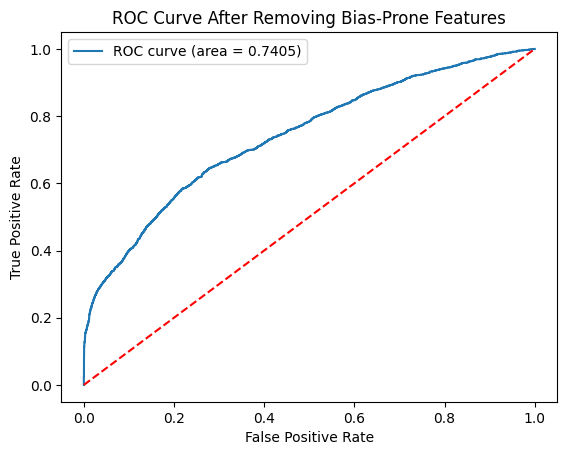

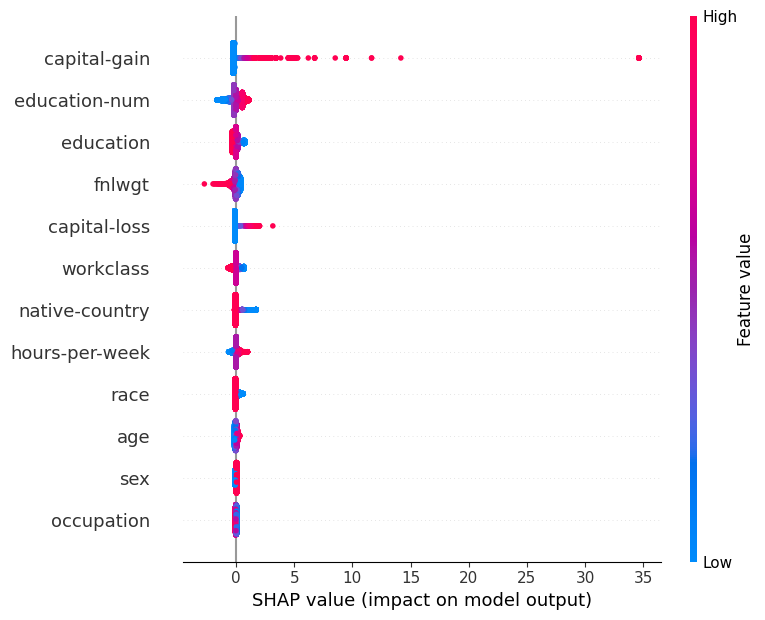

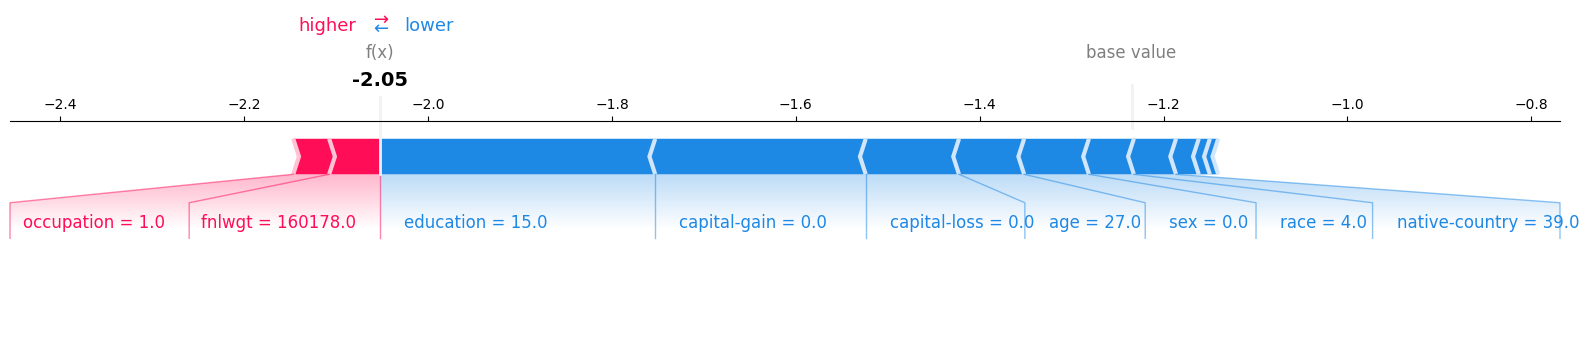

In [10]:
# Remove bias-prone features
X_reduced = X.drop(['relationship', 'marital-status'], axis=1)

# Split data again
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

# Train logistic regression model with reduced features
model_reduced = LogisticRegression(max_iter=1000)
model_reduced.fit(X_train_reduced, y_train)

# Predictions and metrics
y_pred_reduced = model_reduced.predict(X_test_reduced)
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
print(f'Accuracy after removing biased features: {accuracy_reduced:.4f}')

# Other metrics
print("\nClassification Report after removing biased features:\n", classification_report(y_test, y_pred_reduced))

# ROC Curve
y_pred_prob_reduced = model_reduced.predict_proba(X_test_reduced)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_reduced)
roc_auc_reduced = roc_auc_score(y_test, y_pred_prob_reduced)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_reduced:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve After Removing Bias-Prone Features')
plt.legend()
plt.show()

# SHAP Analysis (reduced model)
explainer_reduced = shap.LinearExplainer(model_reduced, X_train_reduced)
shap_values_reduced = explainer_reduced.shap_values(X_test_reduced)

# SHAP Summary Plot
shap.summary_plot(shap_values_reduced, X_test_reduced)

# SHAP Force Plot for a single instance
shap.force_plot(explainer_reduced.expected_value, shap_values_reduced[0,:], X_test_reduced.iloc[0,:], matplotlib=True)


## 2. Bias Mitigation via Reweighting:
Another approach is to apply reweighting to the training data so that certain groups (e.g., based on relationship or marital-status) don't dominate the training process.

Accuracy with bias mitigation via reweighting: 0.8269

Classification Report with bias mitigation via reweighting:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89      7455
           1       0.71      0.45      0.55      2314

    accuracy                           0.83      9769
   macro avg       0.78      0.70      0.72      9769
weighted avg       0.82      0.83      0.81      9769



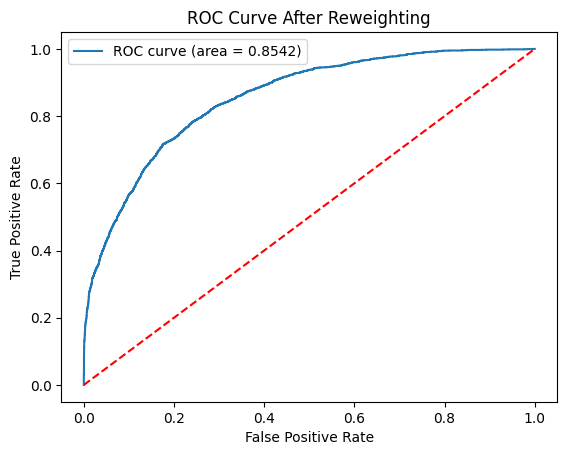

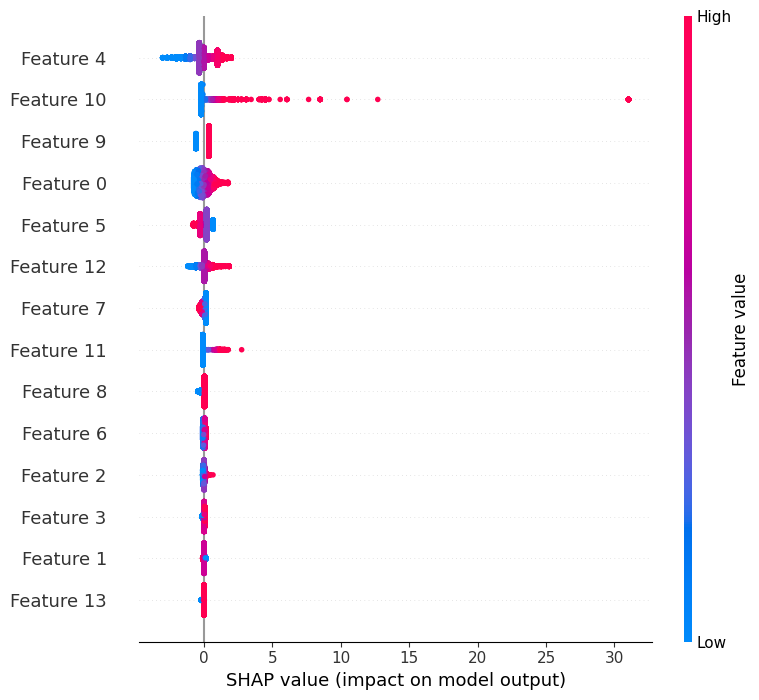

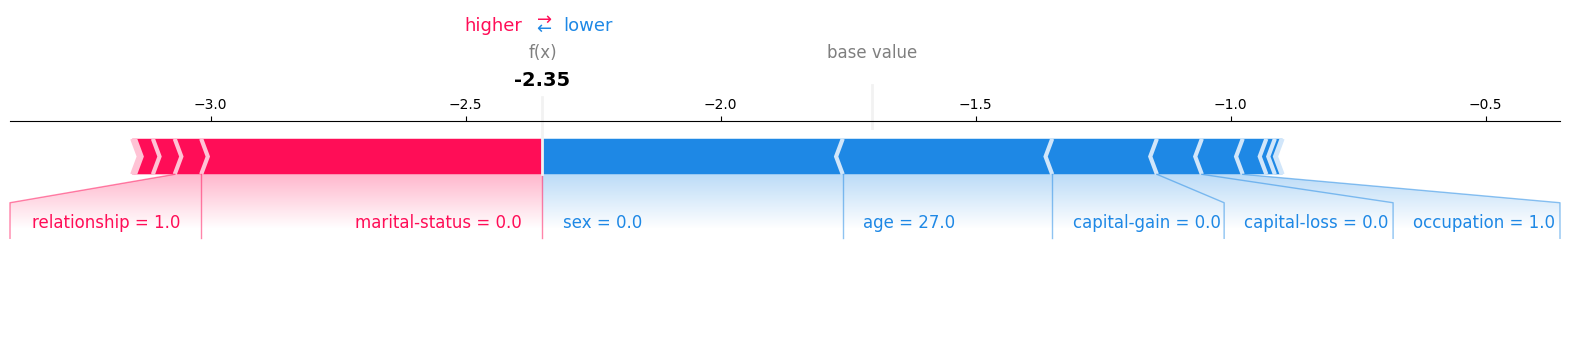

In [12]:
# Add weights based on relationship or marital-status categories to mitigate bias
group_weights = np.where(X['relationship'] == 1, 0.5, 1)  # Example reweighting

# Train logistic regression with sample weights
model_weighted = LogisticRegression(max_iter=1000)
model_weighted.fit(X_train_scaled, y_train, sample_weight=group_weights[:len(y_train)])

# Predictions and metrics
y_pred_weighted = model_weighted.predict(X_test_scaled)
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
print(f'Accuracy with bias mitigation via reweighting: {accuracy_weighted:.4f}')

# Other metrics
print("\nClassification Report with bias mitigation via reweighting:\n", classification_report(y_test, y_pred_weighted))

# ROC Curve
y_pred_prob_weighted = model_weighted.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_weighted)
roc_auc_weighted = roc_auc_score(y_test, y_pred_prob_weighted)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_weighted:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve After Reweighting')
plt.legend()
plt.show()

# SHAP Analysis (weighted model)
explainer_weighted = shap.LinearExplainer(model_weighted, X_train_scaled)
shap_values_weighted = explainer_weighted.shap_values(X_test_scaled)

# SHAP Summary Plot
shap.summary_plot(shap_values_weighted, X_test_scaled)

# SHAP Force Plot for a single instance
shap.force_plot(explainer_weighted.expected_value, shap_values_weighted[0,:], X_test.iloc[0,:], matplotlib=True)


## 3. Fairness Library
The fairlearn library for bias mitigation, such as reweighting or applying constraints to optimize for fairness.

c:\Users\ATHARV\AppData\Local\Programs\Python\Python39\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
c:\Users\ATHARV\AppData\Local\Progra

Accuracy with fairness constraint: 0.7564

Classification Report with fairness constraint:
               precision    recall  f1-score   support

           0       0.77      0.96      0.86      7455
           1       0.43      0.09      0.15      2314

    accuracy                           0.76      9769
   macro avg       0.60      0.53      0.50      9769
weighted avg       0.69      0.76      0.69      9769



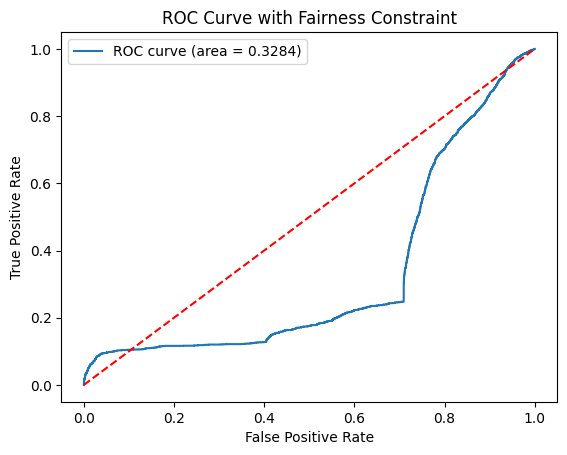

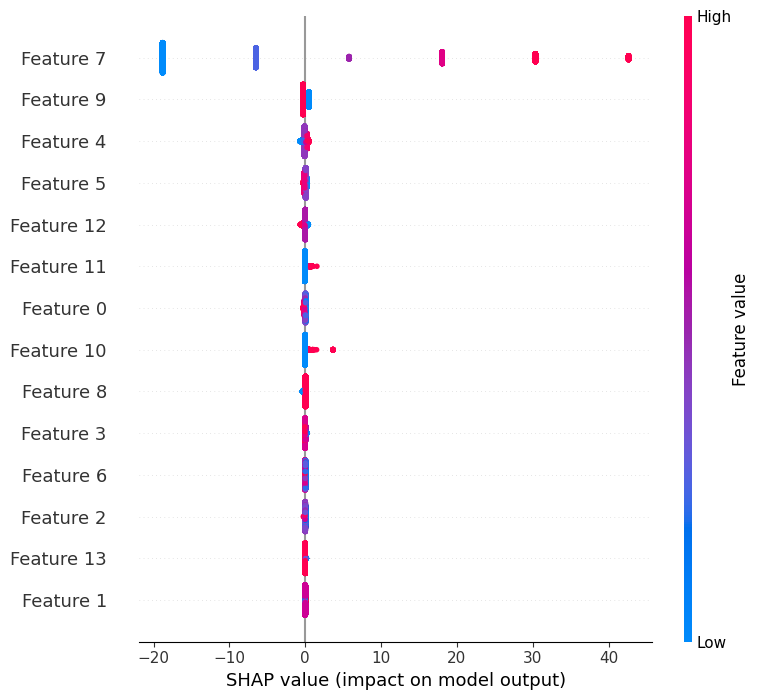

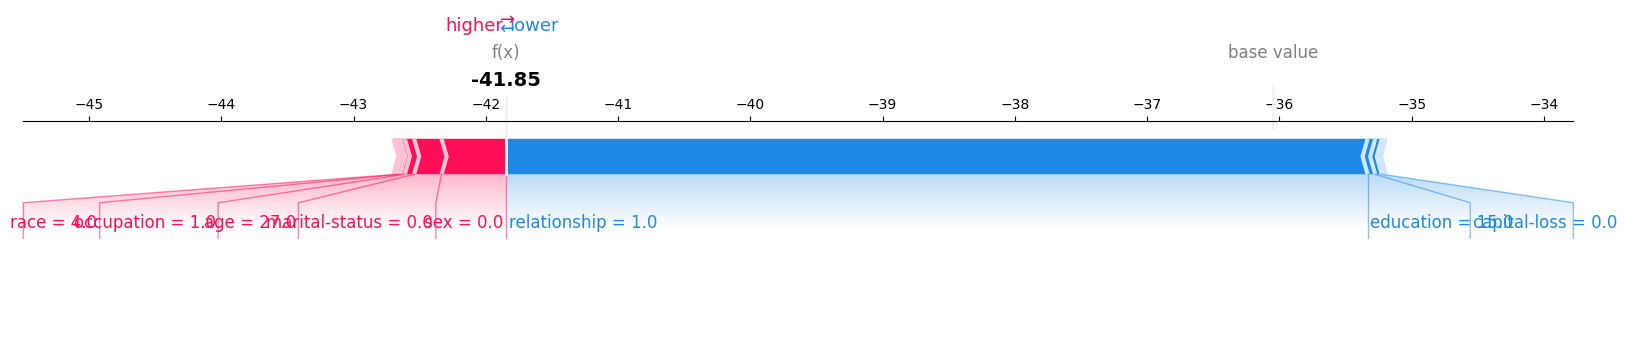

In [18]:
from fairlearn.reductions import GridSearch, DemographicParity
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import shap

# Example: Using Demographic Parity for fairness constraints
sensitive_feature = X_train['relationship']  # Modify this as per your feature

# Create a fairness-aware Logistic Regression model using GridSearch and Demographic Parity constraint
fair_model = GridSearch(LogisticRegression(max_iter=1000),
                        constraints=DemographicParity(),
                        grid_size=10)

# Train fairness model
fair_model.fit(X_train_scaled, y_train, sensitive_features=sensitive_feature)

# Extract the best model (you can customize the selection based on a criterion)
best_fair_model = fair_model.predictors_[0]  # Example: taking the first model (customize as needed)

# Make predictions and evaluate
y_pred_fair = best_fair_model.predict(X_test_scaled)
accuracy_fair = accuracy_score(y_test, y_pred_fair)
print(f'Accuracy with fairness constraint: {accuracy_fair:.4f}')

# Other metrics
print("\nClassification Report with fairness constraint:\n", classification_report(y_test, y_pred_fair))

# ROC Curve
y_pred_prob_fair = best_fair_model.predict_proba(X_test_scaled)[:, 1]
fpr_fair, tpr_fair, _ = roc_curve(y_test, y_pred_prob_fair)
roc_auc_fair = roc_auc_score(y_test, y_pred_prob_fair)
plt.plot(fpr_fair, tpr_fair, label=f'ROC curve (area = {roc_auc_fair:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Fairness Constraint')
plt.legend()
plt.show()

# SHAP Analysis (fair model)
explainer_fair = shap.LinearExplainer(best_fair_model, X_train_scaled)
shap_values_fair = explainer_fair.shap_values(X_test_scaled)

# SHAP Summary Plot
shap.summary_plot(shap_values_fair, X_test_scaled)

# SHAP Force Plot for a single instance
shap.force_plot(explainer_fair.expected_value, shap_values_fair[0,:], X_test.iloc[0,:], matplotlib=True)


## Conclusion:
- Initial Logistic Model (Accuracy: 82): The model had high accuracy but exhibited bias, likely favoring certain groups over others.

- Fair Feature Selection (Accuracy: 80): By removing bias-prone features, the model's accuracy slightly decreased to 80. This trade-off suggests that the removed features contributed to predictive power, but may have also introduced unfair treatment of certain groups.

- Bias Mitigation via Reweighting (Accuracy: 82.69): Reweighting improved accuracy to 82.69 while also addressing bias. This suggests that the model still leveraged all features but adjusted their influence based on group imbalances, leading to a better balance of fairness and predictive performance.

- Fairness Library (Accuracy: 75.64): Applying fairness constraints (e.g., demographic parity) significantly reduced accuracy to 75.64. This shows that stricter fairness constraints can come at the cost of performance, as the model is optimized to be fair across groups, sometimes compromising overall accuracy.

## Ethical Consideration:
- From an ethical standpoint, removing or reducing bias is essential, especially when machine learning models impact people’s lives (e.g., in hiring, lending, healthcare). While accuracy is important, if it comes at the cost of fairness and equality, the model may perpetuate systemic inequalities or unfair treatment.

- Accuracy vs. Fairness: A drop in accuracy (e.g., to 75.64) might seem undesirable, but it is ethically justifiable if it ensures that the model treats all groups fairly. On the other hand, bias mitigation methods like reweighting (which slightly increased accuracy to 82.69) can offer a middle ground, improving fairness without sacrificing much performance.

- Practical Ethics: We should aim to reduce bias, even if it means accepting a slight trade-off in accuracy. Ethical models are more sustainable in the long run, particularly when fairness is a priority in decision-making systems. Models that are biased, even if highly accurate, could lead to legal or reputational risks, as well as social harm.

## Recommendation:
- Given the performance of the bias mitigation techniques, we should reduce bias in your model, opting for a balanced approach such as reweighting or feature selection, which retains much of the model’s predictive power while promoting fairness. However, if ethical and regulatory considerations require stronger fairness constraints, we may consider accepting a greater accuracy drop for more robust fairness.